**Carotid segmentation in ultrasound images with a pre-trained U-net model**

from a dataset containing 1100 common carotid artery ultrasound images

dataset link:https://www.kaggle.com/datasets/orvile/carotid-ultrasound-images

In [ ]:
!pip install -q git+https://github.com/qubvel/segmentation_models.git
!pip install -q tensorflow_addons

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 22.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

**Dataset download**

In [ ]:
import kagglehub

path = kagglehub.dataset_download("orvile/carotid-ultrasound-images")

print("Path to dataset files:", path)

100%|██████████| 284M/284M [00:13<00:00, 21.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2


**Data path**

In [ ]:
img_dir= '/root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/US images'
msk_dir= '/root/.cache/kagglehub/datasets/orvile/carotid-ultrasound-images/versions/2/Common Carotid Artery Ultrasound Images/Common Carotid Artery Ultrasound Images/Expert mask images'

images= sorted(glob.glob(os.path.join(img_dir, '*.png')))
masks= sorted(glob.glob(os.path.join(msk_dir, '*.png')))

print(len(images))
print(len(masks))

1100
1100


**Data splitting**

In [ ]:
import os
import random
import shutil

# Define paths
train_img_dir = "/kaggle/train/images"
train_mask_dir = "/kaggle/train/masks"
val_img_dir = "/kaggle/val/images"
val_mask_dir = "/kaggle/val/masks"
test_img_dir = "/kaggle/test/images"
test_mask_dir = "/kaggle/test/masks"

# Create directories if they don't exist
for dir_path in [train_img_dir, train_mask_dir, val_img_dir, val_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Get all image names and filter only those that have corresponding masks
image_names = set(f for f in os.listdir(img_dir) if f.endswith((".png")))
mask_names = set(f for f in os.listdir(msk_dir) if f.endswith((".png")))

# Ensure only files that exist in both folders are used
valid_image_names = list(image_names.intersection(mask_names))
print(f'unique images and masks: {len(valid_image_names)}')

# Shuffle for randomness
random.seed(42)
random.shuffle(valid_image_names)

# Split the dataset
test_images = valid_image_names[:100]
train_images = valid_image_names[100:850]  # 750 images for training
val_images = valid_image_names[850:1100]   # 250 images for validation

# Function to move files
def move_files(image_list, src_img_dir, src_mask_dir, dest_img_dir, dest_mask_dir):
    for img in image_list:
        shutil.move(os.path.join(src_img_dir, img), os.path.join(dest_img_dir, img))
        shutil.move(os.path.join(src_mask_dir, img), os.path.join(dest_mask_dir, img))

# Move images and corresponding masks
move_files(test_images, img_dir, msk_dir, test_img_dir, test_mask_dir)
move_files(train_images, img_dir, msk_dir, train_img_dir, train_mask_dir)
move_files(val_images, img_dir, msk_dir, val_img_dir, val_mask_dir)

print("Dataset split completed successfully!")


unique images and masks: 1100
Dataset split completed successfully!


In [ ]:
len(train_images)

750

**Showing some train images and their corresponding masks**

Paths exist!
/kaggle/train/images/202202071308300020EM VASCULAR_slice_128.png 
 /kaggle/train/masks/202202071308300020EM VASCULAR_slice_128.png
Paths exist!
/kaggle/train/images/202202071357530054VAS_slice_233.png 
 /kaggle/train/masks/202202071357530054VAS_slice_233.png
Paths exist!
/kaggle/train/images/202201121837530038VAS_slice_551.png 
 /kaggle/train/masks/202201121837530038VAS_slice_551.png
Paths exist!
/kaggle/train/images/202201121805150026VAS_slice_640.png 
 /kaggle/train/masks/202201121805150026VAS_slice_640.png
Paths exist!
/kaggle/train/images/202202071359200056VAS_slice_214.png 
 /kaggle/train/masks/202202071359200056VAS_slice_214.png
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)
(749, 709, 3)
(749, 709)


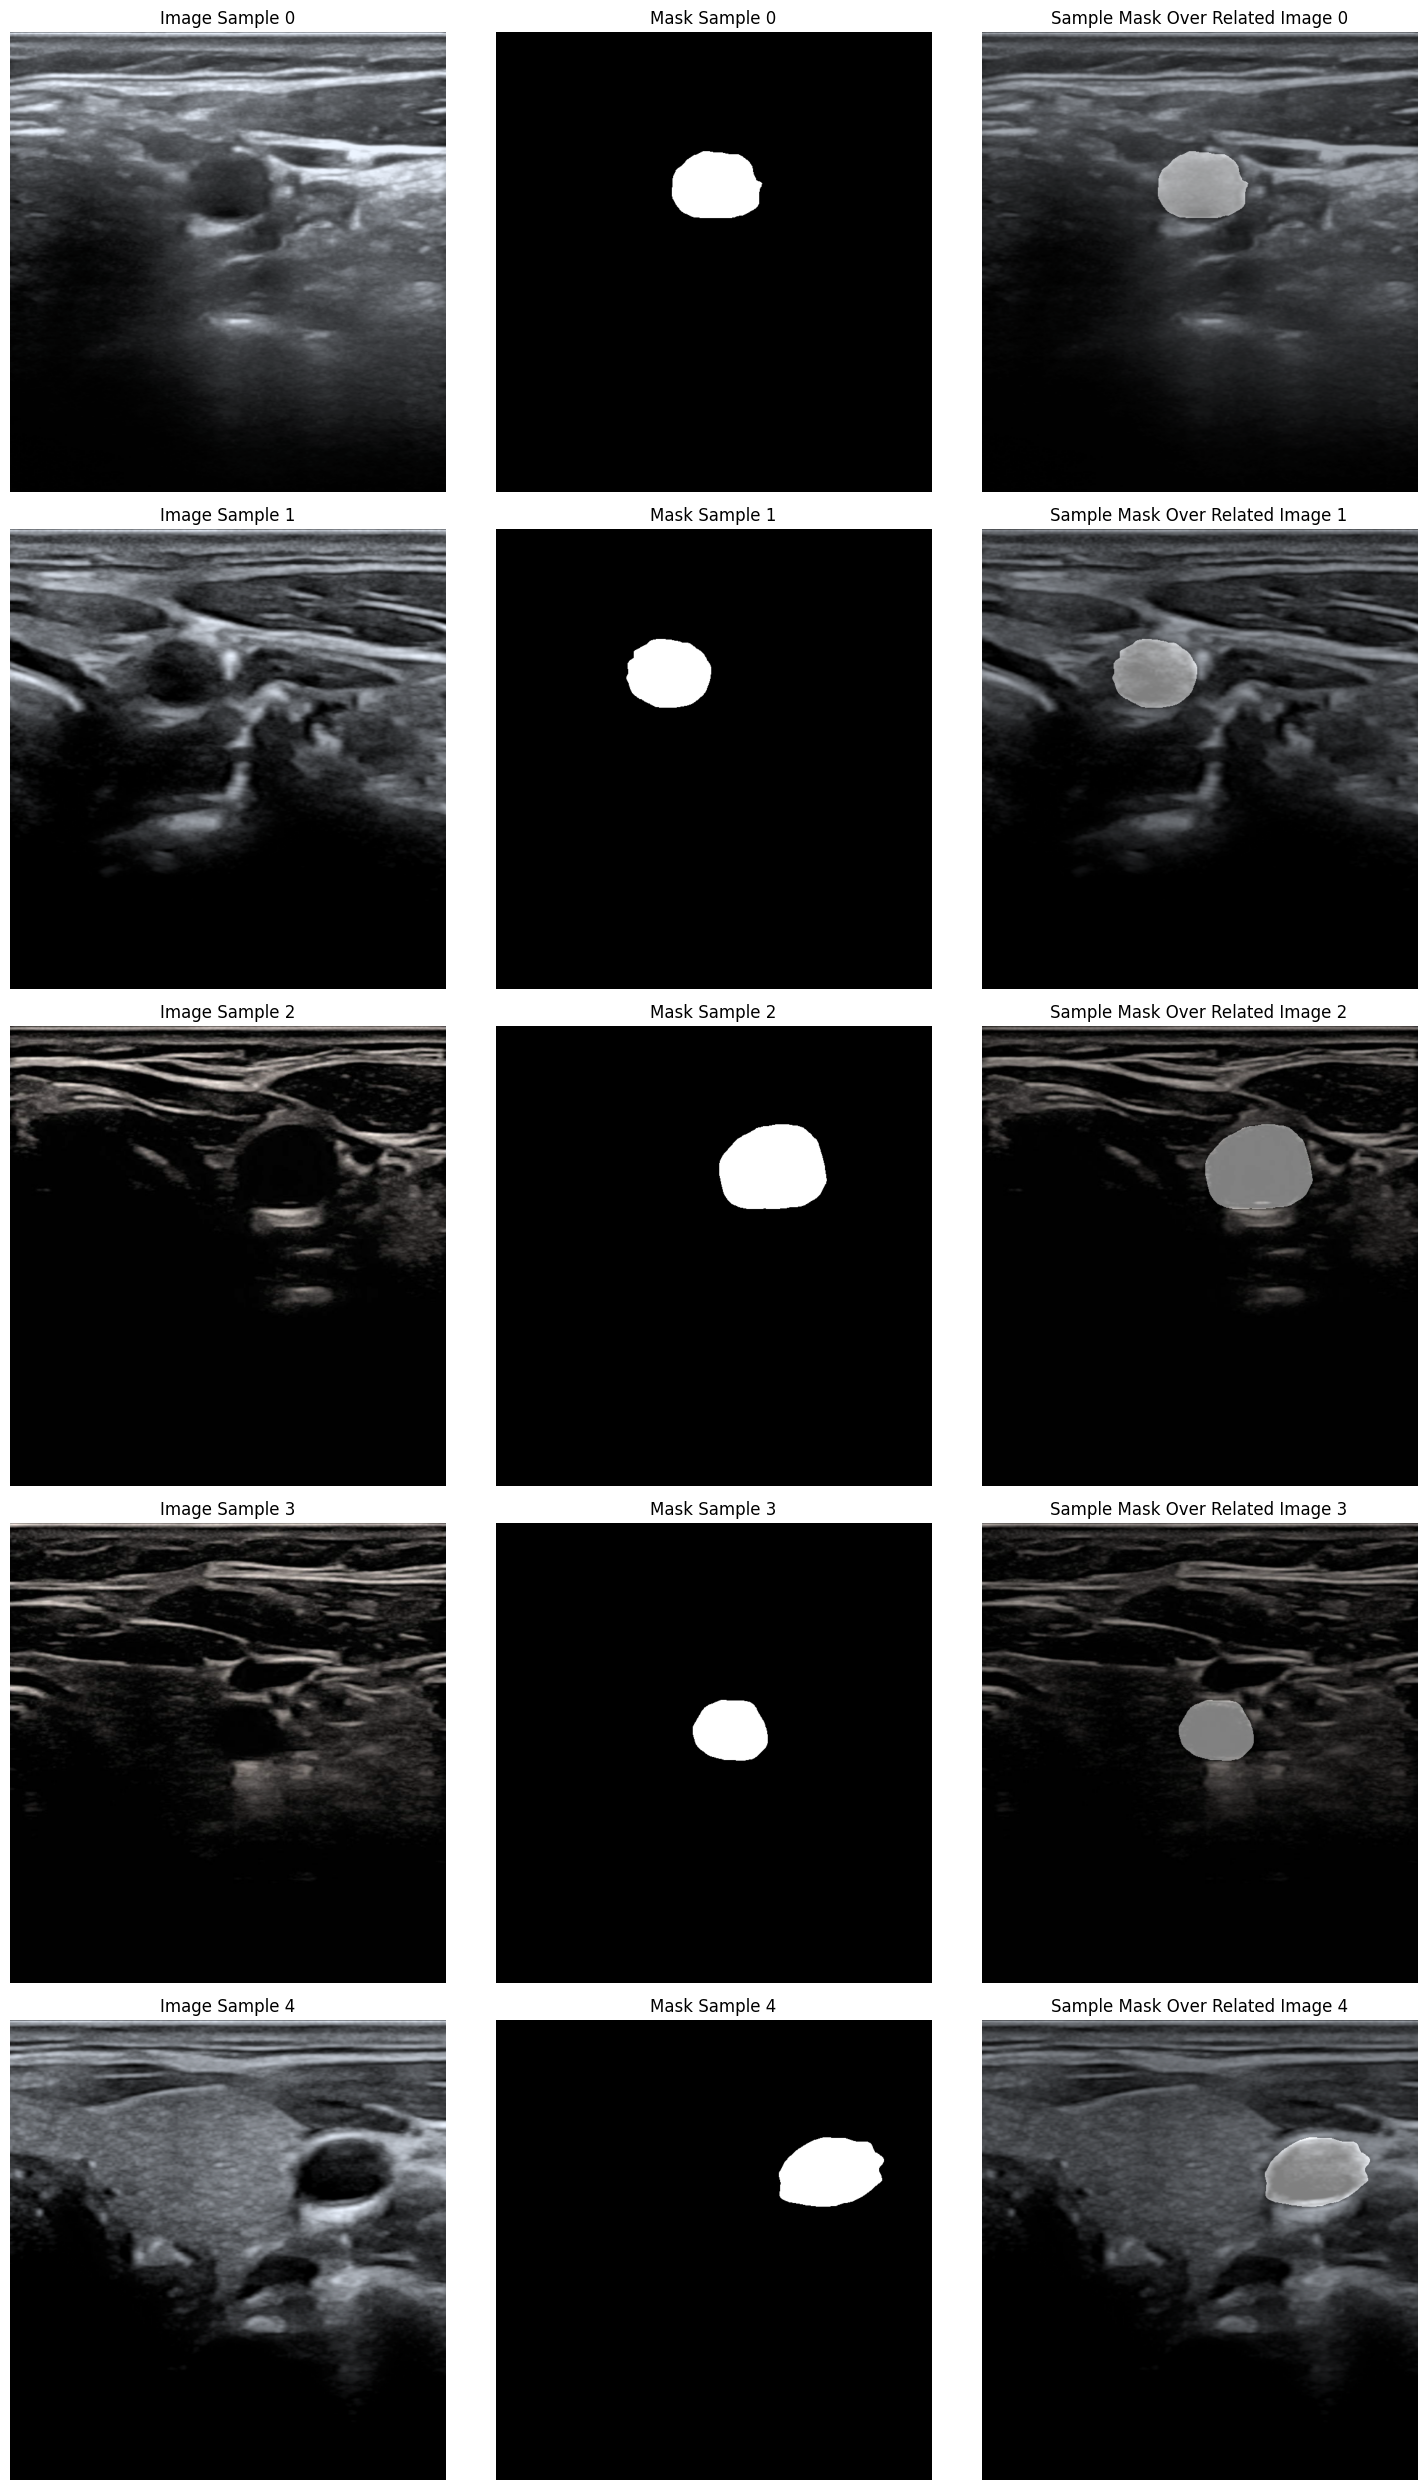

In [ ]:
sam_num = 5
for sam in range(sam_num):
  images = []
  images_paths = []
  masks_paths = []
  images = random.sample(train_images , sam_num)
  for image in images:
    image_path = os.path.join(train_img_dir, image)
    mask_path = os.path.join(train_mask_dir , image)
    images_paths.append(image_path)
    masks_paths.append(mask_path)


# Check if paths exist
for impa , mapa in zip(images_paths , masks_paths):
  if os.path.exists(impa) and os.path.exists(mapa):
    print("Paths exist!")
    print(impa, "\n", mapa)
  else:
    print("One or both paths do not exist. Check your directory structure.")

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5 * sam_num))

for i, (image_path, mask_path) in enumerate(zip(images_paths, masks_paths)):

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    plt.subplot(sam_num, 3, 3 * i + 1)
    plt.title(f"Image Sample {i}")
    plt.imshow(image)
    print(image.shape)
    plt.axis("off")

    plt.subplot(sam_num, 3, 3 * i + 2)
    plt.title(f"Mask Sample {i}")
    plt.imshow(mask, cmap="gray")
    print(mask.shape)
    plt.axis("off")

    overlay = cv2.addWeighted(image, 0.7, cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB), 0.5, 0)
    plt.subplot(sam_num, 3, 3 * i + 3)
    plt.title(f"Sample Mask Over Related Image {i}")
    plt.imshow(overlay)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Resizing images**

In [ ]:
import torch
import cv2
import numpy as np
import os
from skimage.transform import resize
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Function to resize images
def resize_image(image, target_height, target_width):
    return resize(image, (target_height, target_width), mode="constant", preserve_range=True)


def load_data(img_dir, mask_dir):
    img_files = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith((".png", ".jpg", ".jpeg"))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

    X_list, Y_list = [], []

    for img_path, mask_path in tqdm(zip(img_files, mask_files), total=len(img_files)):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"Warning: Could not read {img_path} or {mask_path}")
            continue

        # Resize
        img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True)
        mask_resized = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True).reshape(IMG_HEIGHT, IMG_WIDTH, 1)

        # Normalize and append
        X_list.append(img_resized / 255.0)  # Normalize images
        Y_list.append(mask_resized > 0)  # Convert masks to binary (True for segmented regions)

    return np.array(X_list, dtype=np.float32), np.array(Y_list, dtype=np.float32)

# Load dataset
X_train, Y_train = load_data(train_img_dir, train_mask_dir)
X_val, Y_val = load_data(val_img_dir, val_mask_dir)




100%|██████████| 250/250 [00:22<00:00, 11.05it/s]


**Defining metrics for model training**

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define model save path
model_path = "./nuclei_finder_unet_1.h5"

# Initialize callbacks
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,      # Reduce by half
                              patience=3,      # After 3 epochs with no improvement
                              verbose=1,
                              min_lr=1e-7)     # Don't go below this

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [checkpoint, reduce_lr]

**Using pre-trained U-net for model training**

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from segmentation_models import Unet
from segmentation_models import losses, metrics

model = Unet(
    backbone_name='resnet34',
    encoder_weights='imagenet',
    input_shape=(128, 128, 3),
    classes=1,
    activation='sigmoid'
)

model.compile(
    optimizer=Adam(1e-3),
    loss=losses.DiceLoss(),
    metrics=[
        metrics.IOUScore(threshold=0.5),
        metrics.FScore(threshold=0.5)
    ]
)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - f1-score: 0.4131 - iou_score: 0.2979 - loss: 0.7966
Epoch 1: val_loss improved from inf to 0.93387, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 68s 575ms/step - f1-score: 0.4179 - iou_score: 0.3027 - loss: 0.7936 - val_f1-score: 0.0658 - val_iou_score: 0.0340 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9328 - iou_score: 0.8746 - loss: 0.1994
Epoch 2: val_loss did not improve from 0.93387
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - f1-score: 0.9330 - iou_score: 0.8749 - loss: 0.1982 - val_f1-score: 1.1925e-09 - val_iou_score: 1.1925e-09 - val_loss: 0.9543 - learning_rate: 0.0010
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9553 - iou_score: 0.9146 - loss: 0.0665
Epoch 3: val_loss did not improve from 0.93387
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - f1-score: 0.9553 - iou_score: 0.9145 - loss: 0.0664 - val_f1-score: 1.1925e-09 - val_iou_score: 1.1925e-09 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9560 - iou_score: 0.9158 - loss: 0.0550
Epoch 4: val_lo

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - f1-score: 0.9790 - iou_score: 0.9589 - loss: 0.0251 - val_f1-score: 0.1441 - val_iou_score: 0.0855 - val_loss: 0.8625 - learning_rate: 6.2500e-05
Epoch 17/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1-score: 0.9782 - iou_score: 0.9573 - loss: 0.0257
Epoch 17: val_loss improved from 0.86253 to 0.64708, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - f1-score: 0.9782 - iou_score: 0.9574 - loss: 0.0257 - val_f1-score: 0.3621 - val_iou_score: 0.2424 - val_loss: 0.6471 - learning_rate: 6.2500e-05
Epoch 18/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9787 - iou_score: 0.9583 - loss: 0.0250
Epoch 18: val_loss improved from 0.64708 to 0.34775, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - f1-score: 0.9787 - iou_score: 0.9584 - loss: 0.0250 - val_f1-score: 0.6600 - val_iou_score: 0.5147 - val_loss: 0.3478 - learning_rate: 6.2500e-05
Epoch 19/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9792 - iou_score: 0.9593 - loss: 0.0246
Epoch 19: val_loss improved from 0.34775 to 0.18732, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - f1-score: 0.9792 - iou_score: 0.9593 - loss: 0.0246 - val_f1-score: 0.8180 - val_iou_score: 0.7050 - val_loss: 0.1873 - learning_rate: 6.2500e-05
Epoch 20/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1-score: 0.9796 - iou_score: 0.9599 - loss: 0.0240
Epoch 20: val_loss improved from 0.18732 to 0.12021, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - f1-score: 0.9796 - iou_score: 0.9599 - loss: 0.0240 - val_f1-score: 0.8828 - val_iou_score: 0.7968 - val_loss: 0.1202 - learning_rate: 6.2500e-05
Epoch 21/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9802 - iou_score: 0.9612 - loss: 0.0235
Epoch 21: val_loss improved from 0.12021 to 0.07276, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - f1-score: 0.9802 - iou_score: 0.9612 - loss: 0.0235 - val_f1-score: 0.9290 - val_iou_score: 0.8688 - val_loss: 0.0728 - learning_rate: 6.2500e-05
Epoch 22/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1-score: 0.9802 - iou_score: 0.9611 - loss: 0.0234
Epoch 22: val_loss improved from 0.07276 to 0.06237, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - f1-score: 0.9802 - iou_score: 0.9611 - loss: 0.0234 - val_f1-score: 0.9395 - val_iou_score: 0.8867 - val_loss: 0.0624 - learning_rate: 6.2500e-05
Epoch 23/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9811 - iou_score: 0.9628 - loss: 0.0225
Epoch 23: val_loss improved from 0.06237 to 0.05334, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - f1-score: 0.9811 - iou_score: 0.9628 - loss: 0.0225 - val_f1-score: 0.9483 - val_iou_score: 0.9022 - val_loss: 0.0533 - learning_rate: 6.2500e-05
Epoch 24/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9818 - iou_score: 0.9643 - loss: 0.0215
Epoch 24: val_loss improved from 0.05334 to 0.05228, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - f1-score: 0.9818 - iou_score: 0.9643 - loss: 0.0215 - val_f1-score: 0.9489 - val_iou_score: 0.9033 - val_loss: 0.0523 - learning_rate: 6.2500e-05
Epoch 25/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9809 - iou_score: 0.9625 - loss: 0.0224
Epoch 25: val_loss improved from 0.05228 to 0.04198, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - f1-score: 0.9809 - iou_score: 0.9625 - loss: 0.0224 - val_f1-score: 0.9593 - val_iou_score: 0.9222 - val_loss: 0.0420 - learning_rate: 6.2500e-05
Epoch 26/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9824 - iou_score: 0.9654 - loss: 0.0210
Epoch 26: val_loss did not improve from 0.04198
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - f1-score: 0.9824 - iou_score: 0.9654 - loss: 0.0210 - val_f1-score: 0.9591 - val_iou_score: 0.9217 - val_loss: 0.0424 - learning_rate: 6.2500e-05
Epoch 27/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - f1-score: 0.9826 - iou_score: 0.9657 - loss: 0.0208
Epoch 27: val_loss did not improve from 0.04198
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - f1-score: 0.9826 - iou_score: 0.9657 - loss: 0.0208 - val_f1-score: 0.9587 - val_iou_score: 0.9211 - val_loss: 0.0423 - learning_rate: 6.2500e-05
Epoch 28/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - f1-score: 0.9823 - iou_score: 0.9651 - loss: 0.0210
Epoch 28: val_l

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - f1-score: 0.9824 - iou_score: 0.9654 - loss: 0.0208 - val_f1-score: 0.9604 - val_iou_score: 0.9241 - val_loss: 0.0406 - learning_rate: 3.1250e-05
Epoch 30/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - f1-score: 0.9830 - iou_score: 0.9667 - loss: 0.0200
Epoch 30: val_loss improved from 0.04063 to 0.04028, saving model to ./nuclei_finder_unet_1.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - f1-score: 0.9830 - iou_score: 0.9667 - loss: 0.0200 - val_f1-score: 0.9608 - val_iou_score: 0.9249 - val_loss: 0.0403 - learning_rate: 3.1250e-05


**Model evaluation**

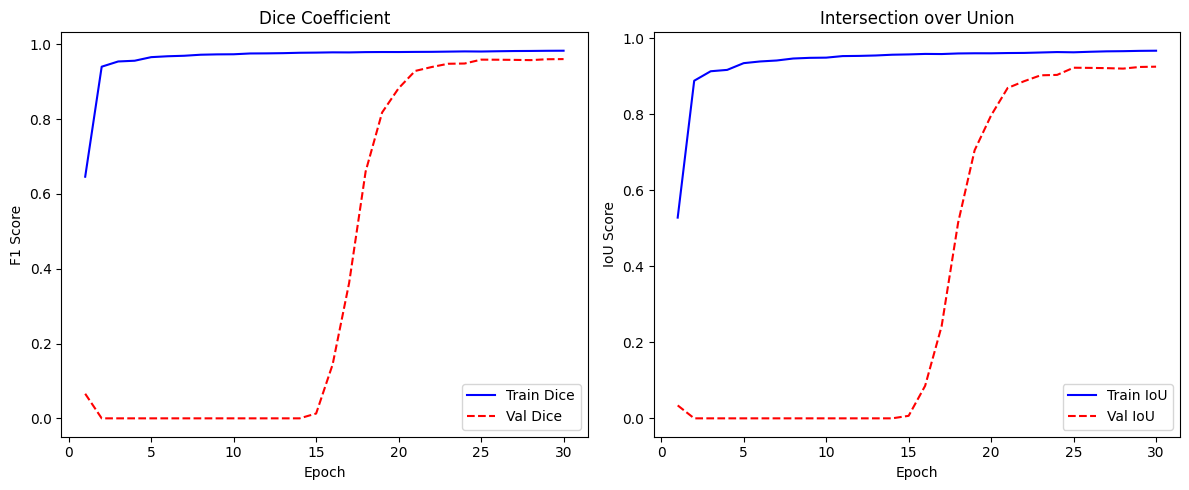

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
dice = history.history['f1-score']
val_dice = history.history['val_f1-score']
iou = history.history['iou_score']
val_iou = history.history['val_iou_score']

epochs = range(1, len(dice) + 1)

# Plot Dice (FScore)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, dice, 'b-', label='Train Dice')
plt.plot(epochs, val_dice, 'r--', label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(epochs, iou, 'b-', label='Train IoU')
plt.plot(epochs, val_iou, 'r--', label='Val IoU')
plt.title('Intersection over Union')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Get the last epoch's metrics
val_dice_final = history.history['val_f1-score'][-1]
val_iou_final = history.history['val_iou_score'][-1]
val_loss_final = history.history['val_loss'][-1]

print(f"Final Validation Dice (F1-score): {val_dice_final:.4f}")
print(f"Final Validation IoU Score     : {val_iou_final:.4f}")
print(f"Final Validation Loss          : {val_loss_final:.4f}")


Final Validation Dice (F1-score): 0.9608
Final Validation IoU Score     : 0.9249
Final Validation Loss          : 0.0403


**Predicted mask for some test images with the trained model**

100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


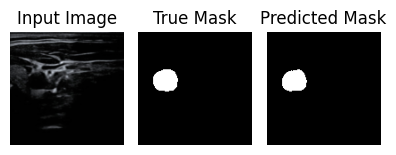

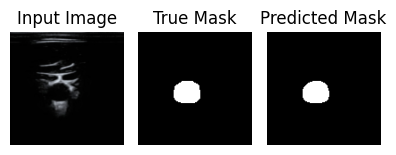

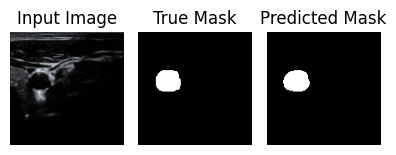

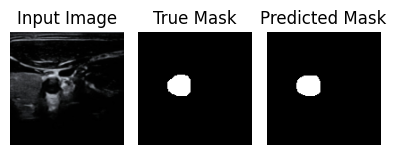

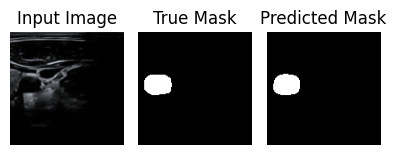

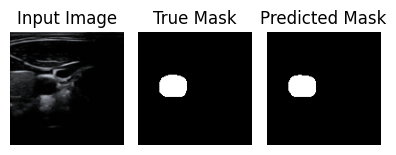

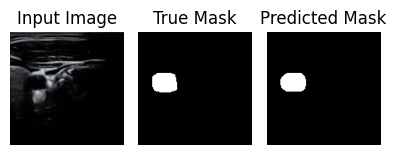

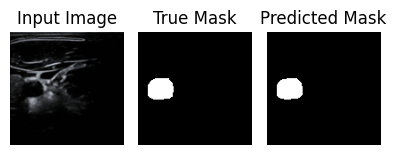

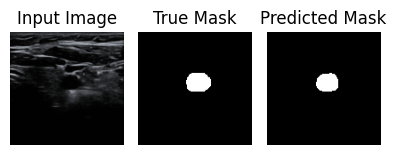

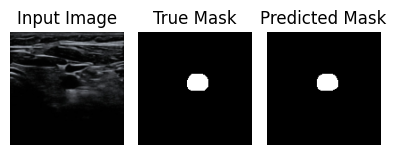

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from segmentation_models import losses, metrics

test_img_dir= '/kaggle/test/images'
test_mask_dir= '/kaggle/test/masks'
# Reuse your preprocessing function
X_test, Y_test = load_data(test_img_dir, test_mask_dir)

model = load_model(
    model_path,
    custom_objects={
        'dice_loss': losses.DiceLoss(),
        'iou_score': metrics.IOUScore(threshold=0.5),
        'f1-score': metrics.FScore(threshold=0.5)
    }
)

# Predict on test data
preds = model.predict(X_test)
preds_binary = (preds > 0.5).astype(np.uint8)

# Plot a few predictions
# Plot 10 predictions with smaller figure sizes
for i in range(min(10, len(X_test))):  # Visualize first 10 samples
    fig, axs = plt.subplots(1, 3, figsize=(4, 2))  # Smaller figure size
    axs[0].imshow(X_test[i])
    axs[0].set_title('Input Image')

    axs[1].imshow(Y_test[i].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')

    axs[2].imshow(preds_binary[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

